# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matminer.featurizers.conversions import StrToComposition
from pymatgen.ext.matproj import MPRester
initial_df = pd.read_csv(r'C:\Users\Fahim\Yr3-Project-1\Python import.csv')

c:\Users\Fahim\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Data exploration**

In [2]:
#print(initial_df.head())
#print(initial_df.columns)
#print(initial_df.describe())
#print(initial_df.info())

**Data cleaning**

In [3]:
#This function will replace '-' values for zeroes. Also replace Nan values with zeroes
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset

In [4]:
#filter columns that are required for us. Also convert some object columns to floats
def column_cleaning(dataset):
    columns_to_keep = ["Catalyst Materials","Family","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data = dataset.loc[:,columns_to_keep]
    columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
    return entropy_data

In [5]:
#Launching functions
initial_df = parse_Nan(initial_df)
entropy_data = column_cleaning(initial_df)
entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']
entropy_data['ΔGOOH*-ΔGOH*'] = entropy_data['ΔGOOH*'] - entropy_data['ΔGOH*']

#print(entropy_data.describe())

**Preparing first graph**

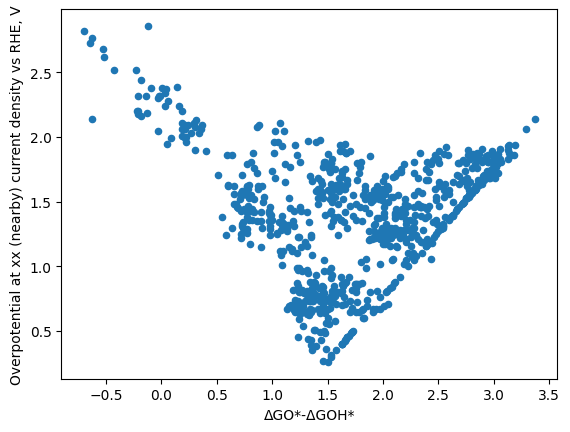

In [6]:
#Slicing only data with values for required columns, then plotting dataset

entropy_data = entropy_data.loc[entropy_data["ΔGO*-ΔGOH*"] != 0.0 ]
entropy_data.plot(x='ΔGO*-ΔGOH*', y = 'Overpotential at xx (nearby) current density vs RHE, V', kind='scatter')
plt.show()

**Clustering**

In [7]:
#Creating an elbow plot to determine how many cluster will be required for model
def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng,sse)
    plt.show()

In [8]:
#Creating cluster plot using K-means method
def cluster_df(cluster_df,n_clusters):
    color = ['black','green','purple','red','blue']
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*-ΔGOH*'],data["Overpotential at xx (nearby) current density vs RHE, V"],c=color[k])
        print(data['Overpotential at xx (nearby) current density vs RHE, V'].max())
    

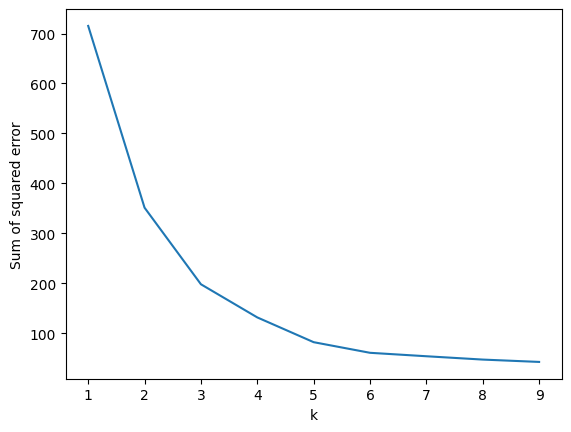

2.14
2.11
2.86
1.89
1.09


Text(0, 0.5, 'Overpotential at xx (nearby) current density vs RHE, V')

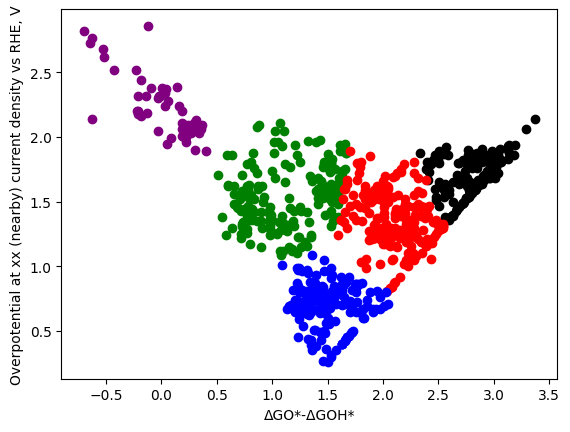

In [9]:
#Placing functions down
elbow_plot(entropy_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(entropy_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
entropy_data['cluster'] = y_predicted
cluster_df(entropy_data,5)
plt.xlabel('ΔGO*-ΔGOH*')
plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')

**Data exploration of optimum cluster**

In [10]:
#Function to determine proprtion of different catalyst materials in each dataset
def printing_stats_1(df_1,df_2,df_3):
    df_names = ['optimum catalysts','filtered initial','initial']
    data = [df_1, df_2 ,df_3] 
    for i in range(0,3):
        print('The number of families in the', df_names[i], 'dataframe + normalized is:')
        print(data[i]['Family'].value_counts())
        print(data[i]['Family'].value_counts(normalize= True))

In [11]:
#Summary statistics on family data on optimum catalysts, catalyst filtered down to our data and the whole initial DF
optimum_catalyst = entropy_data[entropy_data['Overpotential at xx (nearby) current density vs RHE, V']<1.10]
printing_stats_1(optimum_catalyst,entropy_data,initial_df)

The number of families in the optimum catalysts dataframe + normalized is:
Perovskite          176
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.871287
Bimetallic oxide    0.128713
Name: Family, dtype: float64
The number of families in the filtered initial dataframe + normalized is:
Perovskite          805
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.968712
Bimetallic oxide    0.031288
Name: Family, dtype: float64
The number of families in the initial dataframe + normalized is:
Perovskite                                     826
0                                               48
Bimetallic oxide                                26
Noble metal                                     23
Transition metal dichalcogenide                 18
Noble metal oxide                               16
2D TMD, 2H                                       9
2D TMD, 1T                                       7
Transition metal phosphide                       4
Tra

**Element composition featurisation**

In [12]:
#Creating a column for element composition
str_comp = StrToComposition(target_col_id='composition')
entropy_data = str_comp.featurize_dataframe(entropy_data, col_id='Catalyst Materials')
print(entropy_data)

StrToComposition: 100%|██████████| 831/831 [00:37<00:00, 22.08it/s]  


**Accessing material ID from material project + other properties**

In [23]:
with MPRester('CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
    # Use the summary.search method to search for materials with the formula '**O3'
    materials = mpr.summary.search(formula='**O3',fields=['material_id','formula_pretty','band_gap'])
print(materials)
with MPRester('CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
    results = mpr.summary.search(formula='**O3', fields=["material_id", "formula_pretty",'band_gap',"elements"])
    data_list = [(result.material_id, result.formula_pretty, result.band_gap, result.elements) for result in results]
    print(data_list)

Retrieving SummaryDoc documents: 100%|██████████| 2544/2544 [00:04<00:00, 569.08it/s] 


[MPDataDoc<SummaryDoc>(
formula_pretty='NaNbO3',
material_id=MPID(mp-4681),
band_gap=2.3684000000000003,
fields_not_requested=['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'k_voigt', 'k_reuss', 'k_vrh', 'g_vo

Retrieving SummaryDoc documents: 100%|██████████| 2544/2544 [00:01<00:00, 1919.79it/s]

[(MPID(mp-4681), 'NaNbO3', 2.3684000000000003, [Element Na, Element Nb, Element O]), (MPID(mp-754318), 'MnZnO3', 1.3225000000000002, [Element Mn, Element O, Element Zn]), (MPID(mp-1368992), 'MnAlO3', 0.5506000000000002, [Element Al, Element Mn, Element O]), (MPID(mp-545783), 'BaBiO3', 0.0, [Element Ba, Element Bi, Element O]), (MPID(mp-770870), 'MnTlO3', 0.0, [Element Mn, Element O, Element Tl]), (MPID(mp-1376082), 'AlBiO3', 0.7618, [Element Al, Element Bi, Element O]), (MPID(mp-559851), 'CrBiO3', 1.5411000000000001, [Element Bi, Element Cr, Element O]), (MPID(mp-1184349), 'FeRhO3', 0.0, [Element Fe, Element O, Element Rh]), (MPID(mp-1183469), 'BiPtO3', 0.0, [Element Bi, Element O, Element Pt]), (MPID(mp-5039), 'KPO3', 5.0422, [Element K, Element O, Element P]), (MPID(mp-642228), 'MgSiO3', 3.1742, [Element Mg, Element O, Element Si]), (MPID(mp-20032), 'VPbO3', 1.3715000000000002, [Element O, Element Pb, Element V]), (MPID(mp-1427680), 'ZnWO3', 0.0, [Element O, Element W, Element Zn]), 